In [19]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torch import nn
from torch.nn import functional as F
import numpy as np

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# device = torch.device("cpu")

cuda


In [21]:
batch_size = 128
data_fashion = datasets.FashionMNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
loader_fashion = DataLoader(data_fashion, batch_size=batch_size, shuffle=True)

In [22]:
x, y = next(iter(loader_fashion))
print(x.shape)
print(y.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


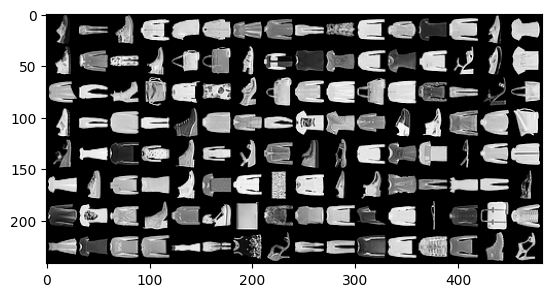

In [26]:
#printing real images
grid =make_grid(x, 8)
grid = grid.permute(2,1,0)
plt.imshow(grid, cmap='gray')
plt.show()

In [27]:
class D(nn.Module):

  def __init__(self):
    super(D, self).__init__()
    self.conv1 = nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
    self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
    self.conv4 = nn.Conv2d(256, 1, kernel_size=4, stride=2, padding=1)


  def forward(self, x):
    x = F.leaky_relu(self.conv1(x), 0.2)
    x = F.leaky_relu(self.conv2(x), 0.2)
    x = F.leaky_relu(self.conv3(x), 0.2)
    x = F.leaky_relu(self.conv4(x), 0.2)
    x = F.sigmoid(x)
    return x



In [29]:
class G(nn.Module):

  def __init__(self):
    super(G, self).__init__()
    self.conv1 = nn.ConvTranspose2d(100, 256, kernel_size=4, stride=1)
    self.conv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=1)
    self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=1 )
    self.conv4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=1 )
    self.conv5 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2)


  def forward(self, x):
    x = self.conv1(x)
    x= nn.BatchNorm2d(256, device=device)(x)
    x = F.relu(x)
    x = self.conv2(x)
    x= nn.BatchNorm2d(128, device=device)(x)
    x = F.relu(x)
    x = self.conv3(x)
    x= nn.BatchNorm2d(64, device=device)(x)
    x = F.relu(x, 0.2)
    x = self.conv4(x)
    x= nn.BatchNorm2d(32, device=device)(x)
    x = F.relu(x, 0.2)
    x= self.conv5(x)
    x = F.tanh(x)
    return x


In [30]:
model_d = D().to(device)
model_g = G().to(device)


In [31]:
z_latent = torch.randn(64, 100, 1, 1).to(device)


In [32]:

model_g(z_latent).shape

torch.Size([64, 1, 28, 28])

In [34]:
bce = nn.BCELoss()
optimizer_d = torch.optim.Adam(model_d.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_g = torch.optim.Adam(model_g.parameters(), lr=0.0002, betas=(0.5, 0.999))

ep_d_loss= []
ep_g_loss = []
for ep in range(10):

  d_loss = []
  g_loss = []

  print(f"Epoch {ep}")
  for x, _ in loader_fashion:
    x_real = x.to(device)
    #descriminator
    optimizer_d.zero_grad()
    z_latent = torch.randn(batch_size, 100, 1, 1).to(device)
    noise = model_g(z_latent)
    out_fake = model_d(noise)

    d_fake = bce(out_fake, torch.zeros_like(out_fake))
    out_real = model_d(x_real)
    d_real = bce(out_real, torch.ones_like(out_real))
    err_d = d_real + d_fake

    err_d.backward()
    optimizer_d.step()
    d_loss.append(err_d.item())

    #generator
    z_latent = torch.randn(batch_size, 100, 1, 1).to(device)
    out_real = model_d(model_g(z_latent))

    err_g = bce(out_real, torch.ones_like(out_real))
    optimizer_g.zero_grad()
    err_g.backward()
    optimizer_g.step()
    g_loss.append(err_g.item())

  ep_g_loss.append(np.array(g_loss).mean())

  ep_d_loss.append(np.array(d_loss).mean())

  print(np.array(d_loss).mean(), np.array(g_loss).mean())


Epoch 0
0.9899508216396482 1.5744208359260803
Epoch 1
1.2126881712789475 0.7931557567134849
Epoch 2
1.0172287777288636 0.891458608067112
Epoch 3
1.0083635220649654 0.9444666914085844
Epoch 4
0.9199968670476982 1.0670584802434389
Epoch 5
0.9735569080818437 1.0278706337724413
Epoch 6
0.9869041384410248 1.01693126349561
Epoch 7
0.9678782891871324 1.0201309578123885
Epoch 8
0.9390333706636165 1.0245343367936515
Epoch 9
0.9278097352239368 1.0507098552641838


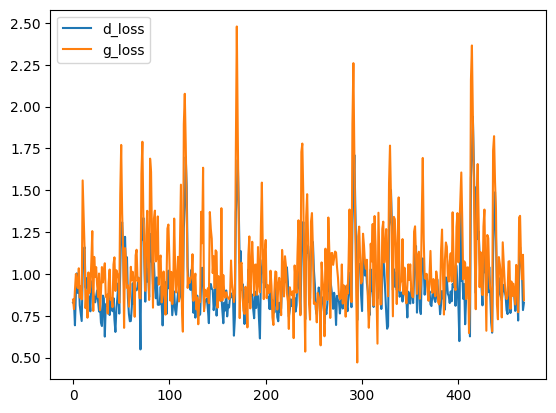

In [35]:
plt.plot(d_loss, label="d_loss")
plt.plot(g_loss, label="g_loss")
plt.legend()
plt.show()

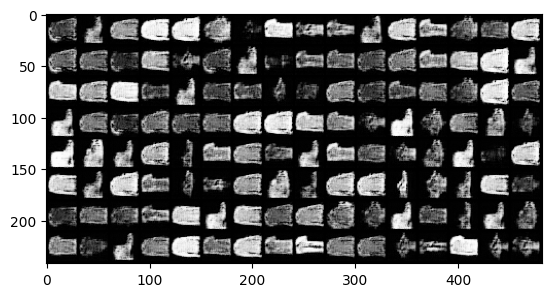

In [37]:
#printing fake images
z_latent = torch.randn(batch_size, 100, 1, 1).to(device)
output =model_g(z_latent)

grid =make_grid(output, 8)
grid = grid.permute(2,1,0)
plt.imshow(grid.cpu().detach().numpy(), cmap='gray')

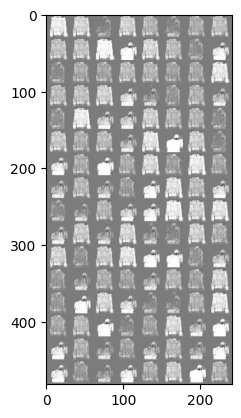

In [ ]:
#printing fake images
z_latent = torch.randn(batch_size, 100, 1, 1).to(device)
output =model_g(z_latent)

grid =make_grid(output, 8)
plt.imshow(grid[0].cpu().detach().numpy(), cmap='gray')

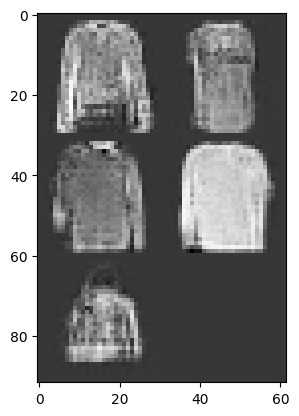

In [ ]:
plt.imshow(grid[0].cpu().detach().numpy(), cmap='gray')

In [ ]:
noise = torch.zeros_like(output)
model_d(output)>0.5



tensor([[[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[False]]],


        [[[